In [11]:
# import libraries

import torch
import time
import copy
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
pip install torchsampler

In [18]:
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import  transforms, datasets
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

    def get_labels(self):
        return [item[1] for item in self.subset]

def check_Image(path):
  try:
    im = Image.open(path)
    im.load()
    return True
  except Exception as e:
    print(f"image path {path} is checked as invalid", str(e))
    return False

# function to creating dataloader
def load_data(data_dir,batch_size=32, num_workers=2 ):

    data_transforms = {

        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),

            transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(),
            transforms.RandomRotation(15),
            transforms.Pad(10),
            transforms.RandomVerticalFlip(),
            transforms.GaussianBlur(3),

            # transfroms.RandomAdjustSharpness(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    }





    ## for trainval folder

    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
    #                                           data_transforms[x])
    #                   for x in ['train', 'val']}

    # class_names = image_datasets['train'].classes
    #_________________________________________________________________

    # for mycati folder

    image_datasets = {}
    all_dataset = datasets.ImageFolder(data_dir,is_valid_file=check_Image)


    train_size = int(0.8 * len(all_dataset))
    test_size = len(all_dataset) - train_size
    image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(all_dataset, [train_size, test_size])

    image_datasets["train"] = MyDataset(image_datasets["train"],data_transforms["train"])

    image_datasets["val"] = MyDataset(image_datasets["val"],data_transforms["val"])
    class_names = all_dataset.classes

    train_loader = torch.utils.data.DataLoader(image_datasets['train'],sampler=ImbalancedDatasetSampler(image_datasets['train']), batch_size=batch_size,  num_workers=num_workers)

    val_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle = True,  num_workers=num_workers)





    #dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                #shuffle=True, num_workers=num_workers)
                #for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    return train_loader, val_loader,class_names, dataset_sizes

In [19]:
from torchsampler import ImbalancedDatasetSampler

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

## visualizing functions

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.savefig('data_augmentation.eps', format='eps')
    plt.pause(0.001)  # pause a bit so that plots are updated


image path /content/drive/MyDrive/raphcatr/HY/50_HY_Germany_Johannes Lang_2020-01-25_M_50.242999_7.70442_NA_.jpg is checked as invalid broken data stream when reading image file


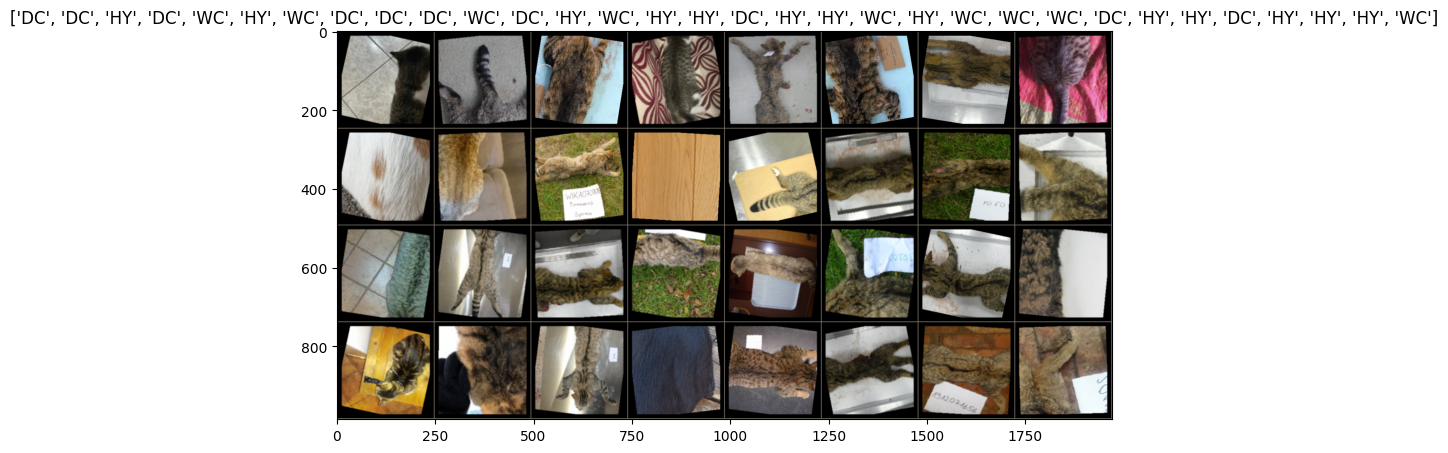

In [21]:
# load data

# hyperparameters

EPOCHS = 5
save_name = "res_1_ce_sgd_b64_train_val_ilr001"
batch_size = 32


data_dir = "/content/drive/MyDrive/raphcatr"


train_loader, val_loader, class_names, dataset_sizes = load_data(data_dir, batch_size)

inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
# Initialize a dictionary to store the count of images per class
class_image_count = {class_name: 0 for class_name in class_names}

# Iterate through the training data loader
for inputs, labels in train_loader:
    for label in labels:
        class_name = class_names[label.item()]
        class_image_count[class_name] += 1

# Print the count of images per class
for class_name, count in class_image_count.items():
    print(f"Class '{class_name}' has {count} images.")


Class 'DC' has 185 images.
Class 'HY' has 198 images.
Class 'WC' has 206 images.


In [23]:
# Initialize a dictionary to store the count of images per class
class_image_count = {class_name: 0 for class_name in class_names}

# Iterate through the training data loader
for inputs, labels in val_loader:
    for label in labels:
        class_name = class_names[label.item()]
        class_image_count[class_name] += 1

# Print the count of images per class
for class_name, count in class_image_count.items():
    print(f"Class '{class_name}' has {count} images.")

Class 'DC' has 37 images.
Class 'HY' has 35 images.
Class 'WC' has 76 images.


In [25]:
#Resnet-18


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")
resnet18 = torchvision.models.resnet18(pretrained=True)
# nofreeze or freeze
for param in resnet18.parameters():
    param.requires_grad = False



# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 3)

resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Device is cuda:0


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [26]:
from torch import optim

# defining loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer_conv = optim.SGD(resnet18.fc.parameters(), lr=0.01, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=1, verbose=True)



Adjusting learning rate of group 0 to 1.0000e-02.


In [27]:


def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_info = {"loss":{}, "accuracy":{}}
    loss_lists = {x: list() for x in ["train","val"]}
    acc_lists = {x:list() for x in ["train","val"]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            loss_lists[phase].append(epoch_loss)
            acc_lists[phase].append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    train_info["loss"].update(loss_lists)
    train_info["accuracy"].update(acc_lists)
    return model, train_info

In [28]:
   # Create a dictionary of dataloaders
dataloaders = {'train': train_loader, 'val': val_loader}
model_conv_resnet, resnet_train_info = train_model(resnet18, criterion, optimizer_conv,
                         exp_lr_scheduler,dataloaders,dataset_sizes,device, num_epochs=25)

Epoch 0/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.2322 Acc: 0.4703
val Loss: 2.0602 Acc: 0.4122

Epoch 1/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.5285 Acc: 0.4873
val Loss: 3.8549 Acc: 0.3986

Epoch 2/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.5314 Acc: 0.5484
val Loss: 2.2509 Acc: 0.5068

Epoch 3/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.7003 Acc: 0.5484
val Loss: 1.2595 Acc: 0.5878

Epoch 4/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.2072 Acc: 0.6095
val Loss: 1.0001 Acc: 0.6824

Epoch 5/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.3534 Acc: 0.5688
val Loss: 1.1337 Acc: 0.6959

Epoch 6/24
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.9704 Acc: 0.6452
val Loss: 1.2692 Acc: 0.6149

Epoch 7/24
----------
Adjusting learning rate of group 0 to 1.0000e-0

In [29]:
!mkdir res

In [30]:
def plot_train_info(train_info):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title("accuracy")
    plt.plot(train_info["accuracy"]["train"],label="Train")
    plt.plot(train_info["accuracy"]["val"],label="Val")
    plt.legend()
    plt.subplot(122)
    plt.title("loss")
    plt.plot(train_info["loss"]["train"],label="Train")
    plt.plot(train_info["loss"]["val"],label="Val")
    plt.legend()

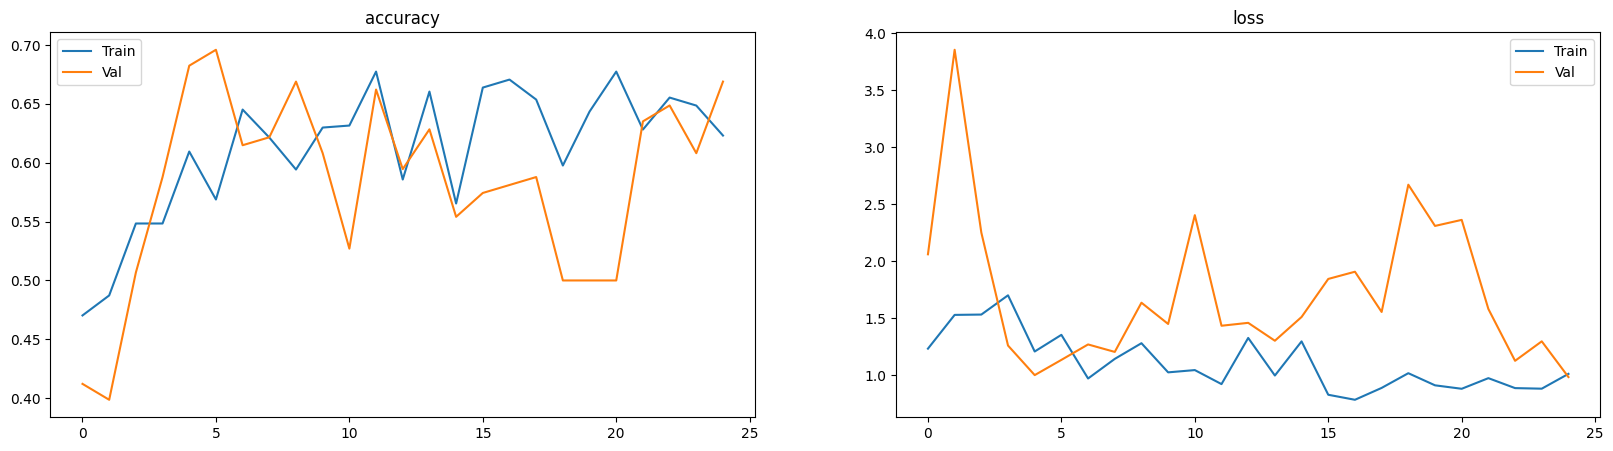

In [33]:
# print(train_info)
save_name = "res_18oversampling_ce_sgd_b64_train_val_ilr001"
plot_train_info(resnet_train_info)
plt.savefig(f"res/{save_name}.eps")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

## visualizing functions

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, dataloaders, class_names, device,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    plt.title("model")

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                label = sorted(class_names)[labels.cpu().data[j]]
                ax.set_title(f'predicted: {class_names[preds[j]]}, label: {label}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [ ]:
class_dict = {0:'DC', 1:'HY', 2:'WC'}
mat = compute_confusion_matrix(model=model_conv_resnet, data_loader=val_loader, device=torch.device('cuda'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.savefig(f'res/{save_name}_confusion.png')
plt.show()